In [1]:
import torch
from torch import nn, optim
import mltools

In [2]:
train_iter, val_iter, test_iter, vocab = mltools.chn_senti_corp('../data/ChnSentiCorp_htl_all.csv')


class TransformerCSCModel(nn.Module):
    '''Transformer 分类模型'''

    def __init__(self, *args, **kwargs):
        '''初始化函数'''
        nn.Module.__init__(self, *args, **kwargs)
        self.embedding = nn.Embedding(num_embeddings=len(vocab), embedding_dim=256, padding_idx=1)  # 定义嵌入层
        encode_layer = nn.TransformerEncoderLayer(d_model=256, nhead=8, batch_first=True)
        self.hidden_layer = nn.TransformerEncoder(encode_layer, num_layers=6)  # 定义隐藏层
        self.output_layer = nn.Linear(256, 2)  # 定义输出层

    def forward(self, x):
        '''前向传播'''
        x = self.embedding(x)  # 将输入嵌入, x形状为(批量大小, 时间步数, 嵌入大小)
        x = self.hidden_layer(x)  # x形状为(批量大小, 时间步数, 隐藏大小)
        x = self.output_layer(x[:, 0, :])  # 它的输出形状是(批量大小, 输出大小)
        return x
    

model = TransformerCSCModel()
device = torch.device('cuda')

In [3]:
class TransformerCSC(mltools.MachineLearning):
    '''Transformer 文本分类学习'''

    def train(self, num_epochs):
        '''迭代训练'''
        mltools.MachineLearning.train(self, num_epochs)
        for _ in range(1, num_epochs + 1):
            self.timer.start()

            # 计算训练集
            metric_train = mltools.Accumulator(2)  # 累加器：(train_loss, train_size)
            self.model.train()  # 训练模式
            for x, y in self.train_iter:
                x = x.to(self.device)  # 转换x
                y = y.to(self.device)  # 转换y
                y_train = self.model(x)  # 计算模型
                train_loss = self.loss(y_train, y)  # 计算训练损失

                # 梯度更新
                self.optimizer.zero_grad()
                train_loss.backward()
                nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1, norm_type=2)
                self.optimizer.step()

                metric_train.add(train_loss * y.numel(), y.numel())
            self.recorder[0].append(metric_train[0] / metric_train[1])

            self.timer.stop()

            # 计算验证集
            metric_val = mltools.Accumulator(3)  # 累加器：(val_loss, val_acc, val_size)
            self.model.eval()  # 验证模式
            with torch.no_grad():
                for x, y in self.val_iter:
                    x = x.to(self.device)  # 转换x
                    y = y.to(self.device)  # 转换y
                    y_val = self.model(x)  # 计算模型
                    val_loss = self.loss(y_val, y)  # 计算验证损失
                    val_pred = y_val.argmax(dim=1)  # 计算预测值
                    val_acc = (val_pred == y).sum()  # 计算验证准确率
                    metric_val.add(val_loss * y.numel(), val_acc, y.numel())
            self.recorder[1].append(metric_val[0] / metric_val[2])
            self.recorder[2].append(metric_val[1] / metric_val[2])

            # 打印输出值
            self.logger.info(f'train loss {self.recorder[0][-1]:.3f}, val loss {self.recorder[1][-1]:.3f}, val acc {self.recorder[2][-1]:.3f}, {self.timer.avg():.1f} sec/epoch on {str(self.device)}')
            self.animator.show(self.recorder.data, legend=['train loss', 'val loss', 'val acc'])  # 添加损失值
        else:
            # 打印输出值
            self.logger.info(f'train loss {self.recorder[0][-1]:.3f}, val loss {self.recorder[1][-1]:.3f}, val acc {self.recorder[2][-1]:.3f}, {self.timer.avg():.1f} sec/epoch on {str(self.device)}')

    def test(self):
        '''测试模型'''
        mltools.MachineLearning.test(self)
        metric = mltools.Accumulator(2)  # 累加器：(test_acc, test_size)
        with torch.no_grad():
            for x, y in self.test_iter:
                x = x.to(self.device)  # 转换x
                y = y.to(self.device)  # 转换y
                y_test = self.model(x)  # 计算模型
                test_pred = y_test.argmax(dim=1)  # 计算准确率
                test_acc = (test_pred == y).sum()  # 计算测试准确率
                metric.add(test_acc, y.numel())
        self.logger.info(f'test acc {metric[0] / metric[1]:.3f}')  # 计算测试准确率并输出

    def predict(self):
        '''预测模型'''
        mltools.MachineLearning.predict(self)
        x, y = next(iter(self.test_iter))  # 从测试中取一个批量
        x = x[:10].to(self.device)
        y = y[:10].to(self.device)
        y_pred = self.model(x)  # 计算模型
        y_pred = y_pred.argmax(dim=1)  # 计算预测
        for content, pred, real in zip(x, y_pred, y):
            print(f'预测值 {pred}, 真实值 {real}, 数据 {''.join(vocab[content.tolist()]).replace('<pad>', ' ')}')


ml = TransformerCSC(model, train_iter, val_iter, test_iter, device=device)

In [4]:
ml.set_loss(nn.CrossEntropyLoss())
ml.set_optimizer(optim.SGD(model.parameters(), lr=1))

2025-05-23 18:35:17,069 - INFO: train loss 1.266, val loss 0.823, val acc 0.704, 68.9 sec/epoch on cuda


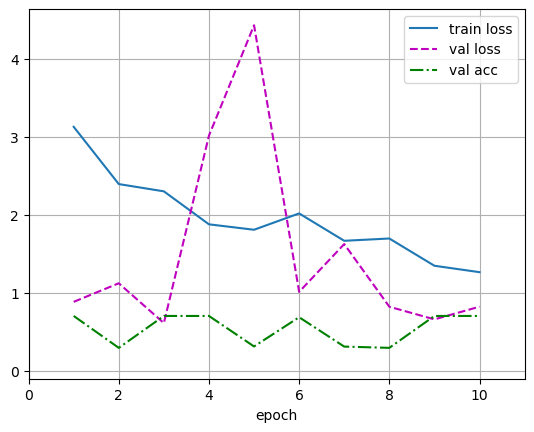

In [5]:
ml.train(num_epochs=10)  # 训练

In [6]:
ml.save()  # 保存

2025-05-23 18:35:17,214 - INFO: save animation to ../results/2025-05-23-18-23-20-TransformerCSC/TransformerCSC.png
2025-05-23 18:35:17,287 - INFO: save model to ../results/2025-05-23-18-23-20-TransformerCSC/TransformerCSC.pth


In [7]:
ml.test()  # 测试

2025-05-23 18:35:20,272 - INFO: test acc 0.681


In [8]:
ml.predict()  # 预测

预测值 1, 真实值 0, 数据 订房间时说,免费延迟退房至16：00点.但是,完全不可能..延迟退房要收半天房费.                                                                                                                                                               
预测值 1, 真实值 1, 数据 家庭套餐的房间有一张双人大床金和一张单人床很贴心。餐厅的鸡汤很好喝。<unk><unk>飞<unk>桌球那里没有工作人员没玩到，钓鱼<unk>有点破，真的想钓鱼最好自己带钓具，除了饭店内的小池塘附近有个小水库可以钓鱼，我家的孩子很喜欢水库附近的小溪可以<unk>水。水库的水很干净但很冰冷有几个当地的孩子还在水库里游泳，尽管那里<unk>着“禁止游泳”的牌子。                                            
预测值 1, 真实值 1, 数据 酒店客房绕池塘而建，池中金鱼频添几分情趣，主客房可餐厅由池塘相隔，安静，优雅。前后两停车场，接客送客相当方便。不足之处，特价房的部分电器较旧。                                                                                                                                 
预测值 1, 真实值 1, 数据 总体感觉还可以，就是觉得性价比不是很高！如果价格可以再低点就不错了。                                                                                                                                                                      
预测值 1, 真实值 1, 数据 房间确实不错，帮朋友订的，朋友说这里的服务很好                                                                